<a href="https://colab.research.google.com/github/taavip/PLANK/blob/main/plank_statistika_kvaliteedi_analyys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install owslib geopandas pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.2 MB/s eta 0:00:00


In [21]:
import pandas as pd
import geopandas as gpd
import requests
from owslib.wfs import WebFeatureService
from concurrent.futures import ThreadPoolExecutor, as_completed
import math

# WFS teenuse URL
url = 'https://planeeringud.ee/plank/wfs?'

# Loome ühenduse WFS teenusega
wfs = WebFeatureService(url=url, version="2.0.0")

# Loeme kõik saadaval olevad kihid teenuses
layers = list(wfs.contents)

# Kuvame kõik saadaval olevad kihid
print("Saadaval kihid WFS teenuses:")
for layer in layers:
    print(layer)

# Funktsioon, mis laadib kihi andmed WFS teenusest
def load_layer_data(layer_name):
    print(f"\nLaen kihti: {layer_name}")  # Kuvame, millist kihti hetkel laeme

    # Määrame päringu parameetrid
    params = dict(service='WFS', version="2.0.0", request='GetFeature',
                  typeNames=layer_name, startIndex=0, count=1000, outputFormat='text/xml; subtype=gml/3.2.1')

    all_gdf = []
    page = 0

    while True:
        # Arvutame startIndex järgmisele lehele
        params['startIndex'] = page * 1000

        # Koostame päringu URL
        wfs_request_url = requests.Request('GET', url, params=params).prepare().url
        response = requests.get(wfs_request_url)

        # Laeme andmed GeoPandasiga
        try:
            gdf = gpd.read_file(wfs_request_url)
            all_gdf.append(gdf)

            # Kui tagastati vähem kui 1000 kirjet, lõpetame
            if len(gdf) < 1000:
                break

            # Jätkame järgmise lehega
            page += 1

        except Exception as e:
            print(f"Viga kihi {layer_name} laadimisel lehelt {page + 1}: {e}")
            break

    # Ühendame kõik lehed üheks GeoDataFrame'iks
    if all_gdf:
        combined_gdf = gpd.GeoDataFrame(pd.concat(all_gdf, ignore_index=True))
        return combined_gdf
    else:
        print(f"Ei leitud andmeid kihil {layer_name}.")
        return None

# Lae kõik kihid paralleelselt
def load_all_layers_parallel(layers):
    gdfs = {}
    with ThreadPoolExecutor(max_workers=8) as executor:  # Tõstetud töötlejate arv
        # Laadime kõik kihid paralleelselt ja kogume tulemusi
        futures = {executor.submit(load_layer_data, layer): layer for layer in layers}

        for future in as_completed(futures):
            layer = futures[future]
            try:
                gdf = future.result()
                if gdf is not None:
                    gdfs[layer] = gdf
                    print(f"Kihil {layer} on {len(gdf)} rida andmeid.")
            except Exception as e:
                print(f"Kihi {layer} laadimisel tekkis viga: {e}")

    return gdfs

# Laeme kõik kihid paralleelselt (nt võtame ainult esimese 10 kihi)
gdfs = load_all_layers_parallel(layers[38:39])

# Kontrollime tulemusi
print(f"Leitud GeoDataFrame'id: {len(gdfs)}")
for layer_name, gdf in gdfs.items():
    print(f"Kihi {layer_name} veerud: {gdf.columns}")


Saadaval kihid WFS teenuses:
plank:yrpmsp
plank:yrpmsp_kihid
plank:yrpmsp_kihid_2
plank:yrpmsp_kihid_1
plank:maakonnaplaneeringu_ala
plank:mp_msp
plank:mp_msp_2
plank:mp_msp_1
plank:mp_tuuleala
plank:mp_vesiviljelus
plank:mp_rohev
plank:mp_toimepiirkond
plank:mp_linnaline
plank:mp_suunis
plank:mp_suunis_2
plank:mp_suunis_1
plank:mp_vaartala
plank:mp_vaartala_2
plank:mp_vaartala_1
plank:mp_taristu
plank:mp_taristu_2
plank:mp_taristu_1
plank:mp_keskus
plank:yldplaneeringud
plank:yp_tiheasustus
plank:yp_maakasutus
plank:yp_dpkoko
plank:yp_ekv
plank:yp_ekv_1
plank:yp_tingimus
plank:yp_tingimus_2
plank:yp_tingimus_1
plank:yp_ehitis
plank:yp_ehitis_2
plank:yp_ehitis_1
plank:yp_transport_3
plank:yp_transport
plank:yp_transport_1
plank:detailplaneering
plank:dp_krunt
plank:dp_hoonestus
plank:dp_tingimus
plank:dp_tingimus_2
plank:dp_tingimus_1
plank:dp_transp_3
plank:dp_transp
plank:dp_transp_1
plank:dp_tehno_3
plank:dp_tehno
plank:dp_tehno_1
plank:kep_ala
plank:kep_krunt
plank:kep_hoonestus
pl

In [22]:
gdfs['plank:detailplaneering'].dtypes

,0
gml_id,object
lowerCorner,object
upperCorner,object
sysid,int32
planid,float64
kovid,object
plannim,object
korraldaja,object
planseis_nimi,object
planksh,object


In [23]:
gdfs['plank:detailplaneering']['algkp'] = pd.to_datetime(gdfs['plank:detailplaneering']['timePosition'], errors='coerce')
gdfs['plank:detailplaneering']['vastuvkp'] = pd.to_datetime(gdfs['plank:detailplaneering']['vastuvkp|timePosition'], errors='coerce')
gdfs['plank:detailplaneering']['kehtestkp'] = pd.to_datetime(gdfs['plank:detailplaneering']['kehtestkp|timePosition'], errors='coerce')
gdfs['plank:detailplaneering']['tyhistkp'] = pd.to_datetime(gdfs['plank:detailplaneering']['tyhistkp|timePosition'], errors='coerce')

# Delete the original columns
gdfs['plank:detailplaneering'].drop(['timePosition', 'vastuvkp|timePosition', 'kehtestkp|timePosition', 'tyhistkp|timePosition'], axis=1, inplace=True)

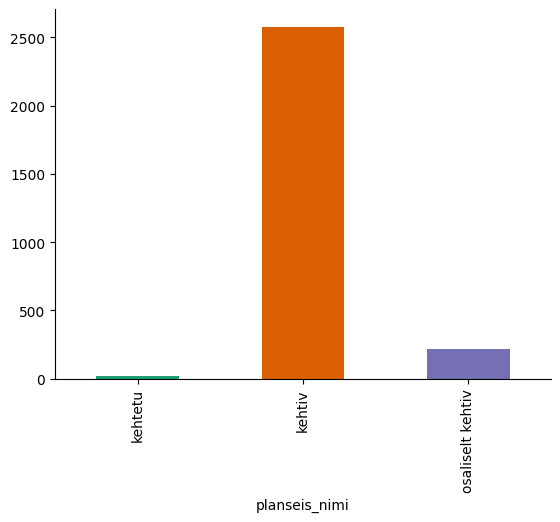

In [18]:
# @title planseis_nimi

from matplotlib import pyplot as plt
import seaborn as sns
gdf.groupby('planseis_nimi').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
gdfs['plank:detailplaneering']['algkp']

,algkp
0,2002-04-18
1,2001-03-07
2,2002-06-26
3,2005-01-11
4,2017-10-27
...,...
2810,2021-06-25
2811,2022-05-27
2812,2024-03-11
2813,2023-12-20


In [27]:
from datetime import datetime

# Create a datetime object for 1.1.1970
cutoff_date = datetime(1970, 1, 1)

# Filter the GeoDataFrame for each datetime column
filtered_rows = {}
for col in gdfs['plank:detailplaneering'].select_dtypes(include=['datetime']).columns:
    filtered_rows[col] = gdfs['plank:detailplaneering'][gdfs['plank:detailplaneering'][col] < cutoff_date]

# Print the filtered rows for each column
for col, rows in filtered_rows.items():
    print(f"Rows with dates before 1.1.1970 in column '{col}':")
    print(rows)

Rows with dates before 1.1.1970 in column 'algkp':
Empty GeoDataFrame
Columns: [gml_id, lowerCorner, upperCorner, sysid, planid, kovid, plannim, korraldaja, planseis_nimi, planksh, muutev, planeesm, url, failid, planviide, geometry, algkp, vastuvkp, kehtestkp, tyhistkp]
Index: []
Rows with dates before 1.1.1970 in column 'vastuvkp':
Empty GeoDataFrame
Columns: [gml_id, lowerCorner, upperCorner, sysid, planid, kovid, plannim, korraldaja, planseis_nimi, planksh, muutev, planeesm, url, failid, planviide, geometry, algkp, vastuvkp, kehtestkp, tyhistkp]
Index: []
Rows with dates before 1.1.1970 in column 'kehtestkp':
Empty GeoDataFrame
Columns: [gml_id, lowerCorner, upperCorner, sysid, planid, kovid, plannim, korraldaja, planseis_nimi, planksh, muutev, planeesm, url, failid, planviide, geometry, algkp, vastuvkp, kehtestkp, tyhistkp]
Index: []
Rows with dates before 1.1.1970 in column 'tyhistkp':
Empty GeoDataFrame
Columns: [gml_id, lowerCorner, upperCorner, sysid, planid, kovid, plannim, ko

In [26]:
from datetime import datetime

# Create a datetime object for 1.1.1970
cutoff_date = datetime(1970, 1, 1)

# Create a dictionary to store filtered rows and their counts
filtered_rows_and_counts = {}

# Filter and count rows for each datetime column
for col in gdfs['plank:detailplaneering'].select_dtypes(include=['datetime']).columns:
    # Filter rows
    filtered_rows = gdfs['plank:detailplaneering'][gdfs['plank:detailplaneering'][col] < cutoff_date]

    # Store filtered rows and count in the dictionary
    filtered_rows_and_counts[col] = {
        'rows': filtered_rows,
        'count': len(filtered_rows)
    }

    # Change dates to NaT in the original dataframe
    gdfs['plank:detailplaneering'].loc[gdfs['plank:detailplaneering'][col] < cutoff_date, col] = pd.NaT

# Print the counts
for col, data in filtered_rows_and_counts.items():
    print(f"Column '{col}': {data['count']} rows with dates before 1.1.1970")

# Access the filtered rows using filtered_rows_and_counts[column_name]['rows']
# For example, to access the rows for the 'algkp' column:
filtered_algkp_rows = filtered_rows_and_counts['algkp']['rows']

Column 'algkp': 3 rows with dates before 1.1.1970
Column 'vastuvkp': 150 rows with dates before 1.1.1970
Column 'kehtestkp': 0 rows with dates before 1.1.1970
Column 'tyhistkp': 0 rows with dates before 1.1.1970


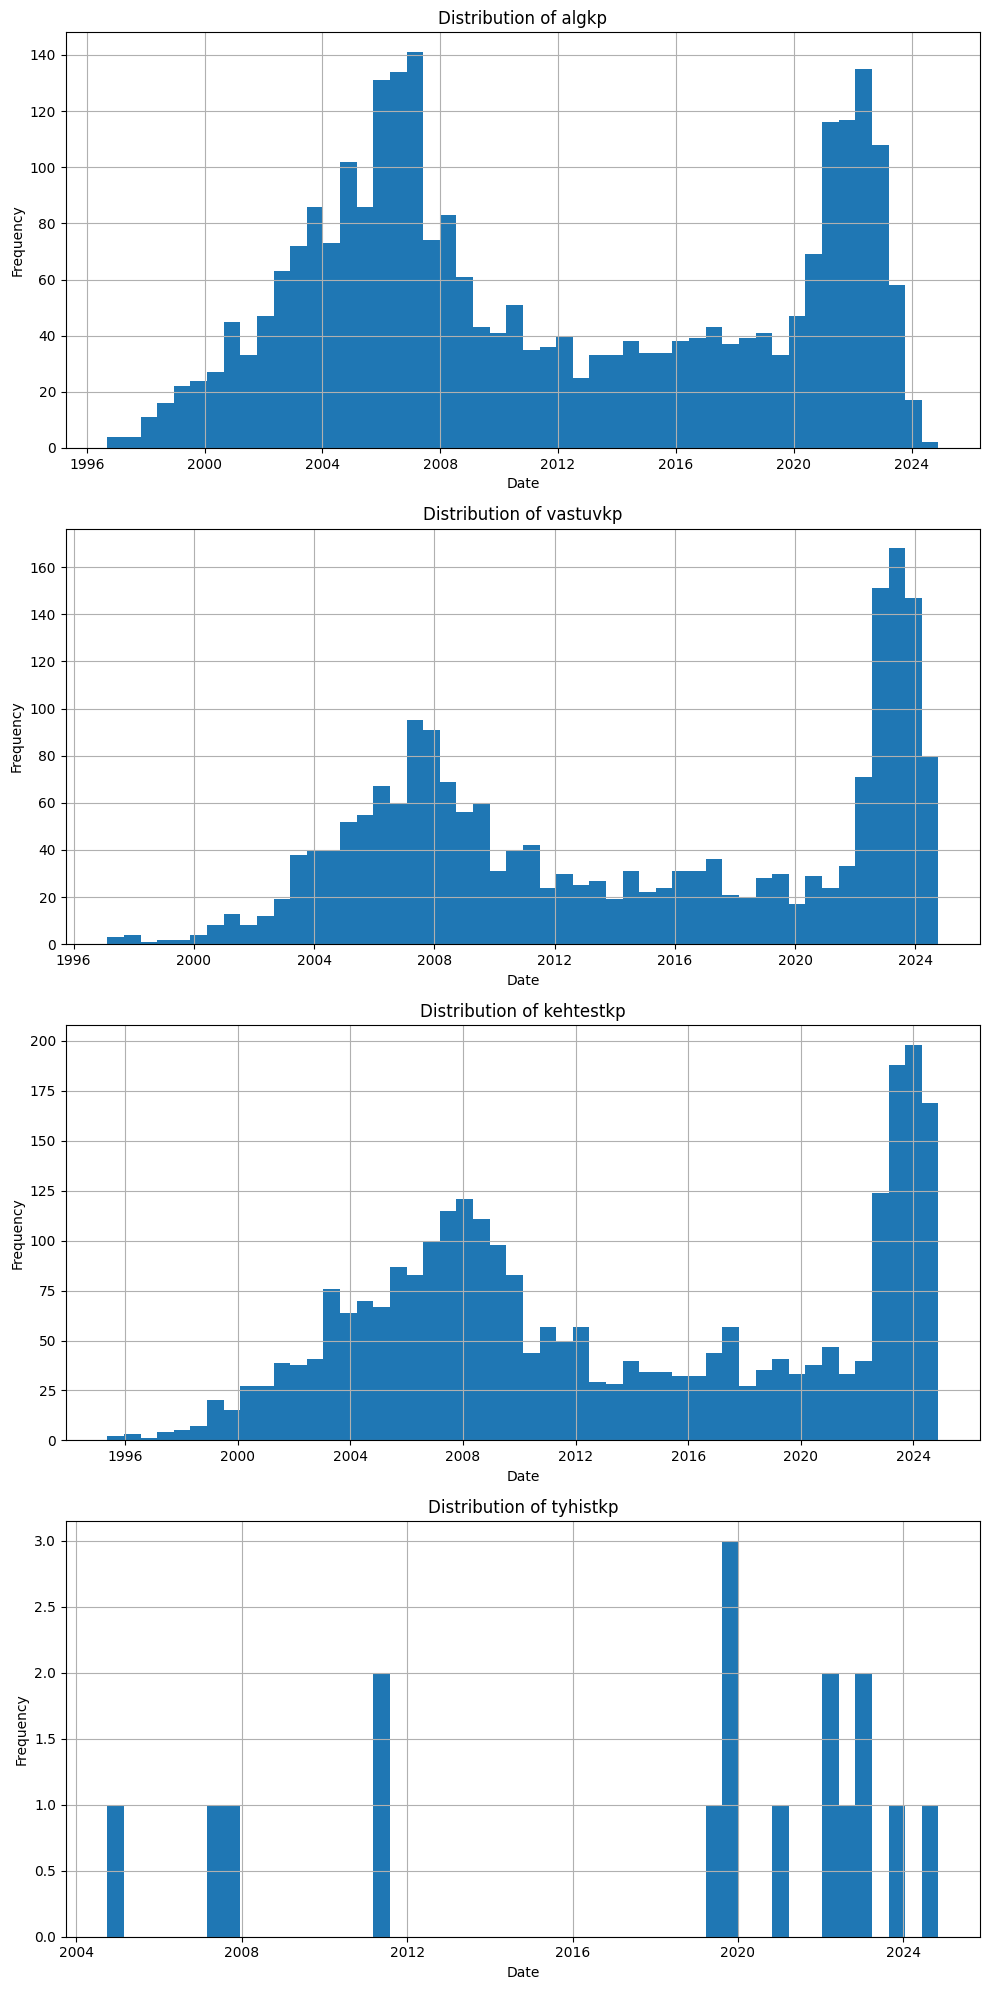

In [28]:
import matplotlib.pyplot as plt

# Select only the datetime columns
datetime_cols = gdfs['plank:detailplaneering'].select_dtypes(include=['datetime']).columns

# Create subplots for each datetime column
fig, axes = plt.subplots(len(datetime_cols), 1, figsize=(10, 5 * len(datetime_cols)), sharex=False)  # Adjust figsize as needed

# Plot the distribution for each column
for i, col in enumerate(datetime_cols):
    ax = axes[i]
    gdfs['plank:detailplaneering'][col].hist(ax=ax, bins=50)  # Adjust bins as needed
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
gdfs['plank:detailplaneering']['algkp_vastuvkp_days'] = (gdfs['plank:detailplaneering']['vastuvkp'] - gdfs['plank:detailplaneering']['algkp']).dt.days
gdfs['plank:detailplaneering']['algkp_kehtestkp_days'] = (gdfs['plank:detailplaneering']['kehtestkp'] - gdfs['plank:detailplaneering']['algkp']).dt.days
gdfs['plank:detailplaneering']['algkp_tyhistkp_days'] = (gdfs['plank:detailplaneering']['tyhistkp'] - gdfs['plank:detailplaneering']['algkp']).dt.days
gdfs['plank:detailplaneering']['vastuvkp_kehtestkp_days'] = (gdfs['plank:detailplaneering']['kehtestkp'] - gdfs['plank:detailplaneering']['vastuvkp']).dt.days
gdfs['plank:detailplaneering']['kehtestkp_tyhistkp_days'] = (gdfs['plank:detailplaneering']['tyhistkp'] - gdfs['plank:detailplaneering']['kehtestkp']).dt.days

In [37]:
# Get a list of columns with calculated day differences
day_diff_cols = [col for col in gdfs['plank:detailplaneering'].columns if col.endswith('_days')]

# Create a boolean mask to identify rows with negative values in any of the day difference columns
negative_mask = gdfs['plank:detailplaneering'][day_diff_cols].lt(0).any(axis=1)

# Filter the GeoDataFrame using the mask
negative_rows = gdfs['plank:detailplaneering'][negative_mask]

# Print the negative rows
print(negative_rows)

                         gml_id                   lowerCorner  \
83    detailplaneering.30103362  6444867.199999 704553.880000   
106   detailplaneering.30100105  6592181.140000 580137.150000   
119   detailplaneering.30100234  6609013.130000 608246.030000   
336   detailplaneering.30100435  6574538.960000 591955.720000   
347   detailplaneering.30100497  6579040.980000 569195.630000   
359   detailplaneering.30100463  6573167.660000 592238.480000   
389   detailplaneering.30100410  6608761.730000 607861.000000   
468   detailplaneering.30100573  6571332.300000 501550.840000   
473   detailplaneering.30102413  6582134.890000 561328.220000   
522   detailplaneering.30100634  6583928.277368 668760.444508   
529   detailplaneering.30100645  6594904.880000 579567.380000   
585   detailplaneering.30100671  6590671.200000 554400.670000   
586   detailplaneering.30103243  6479176.950000 530101.750303   
665   detailplaneering.30100993  6525494.308083 631655.962089   
684   detailplaneering.30

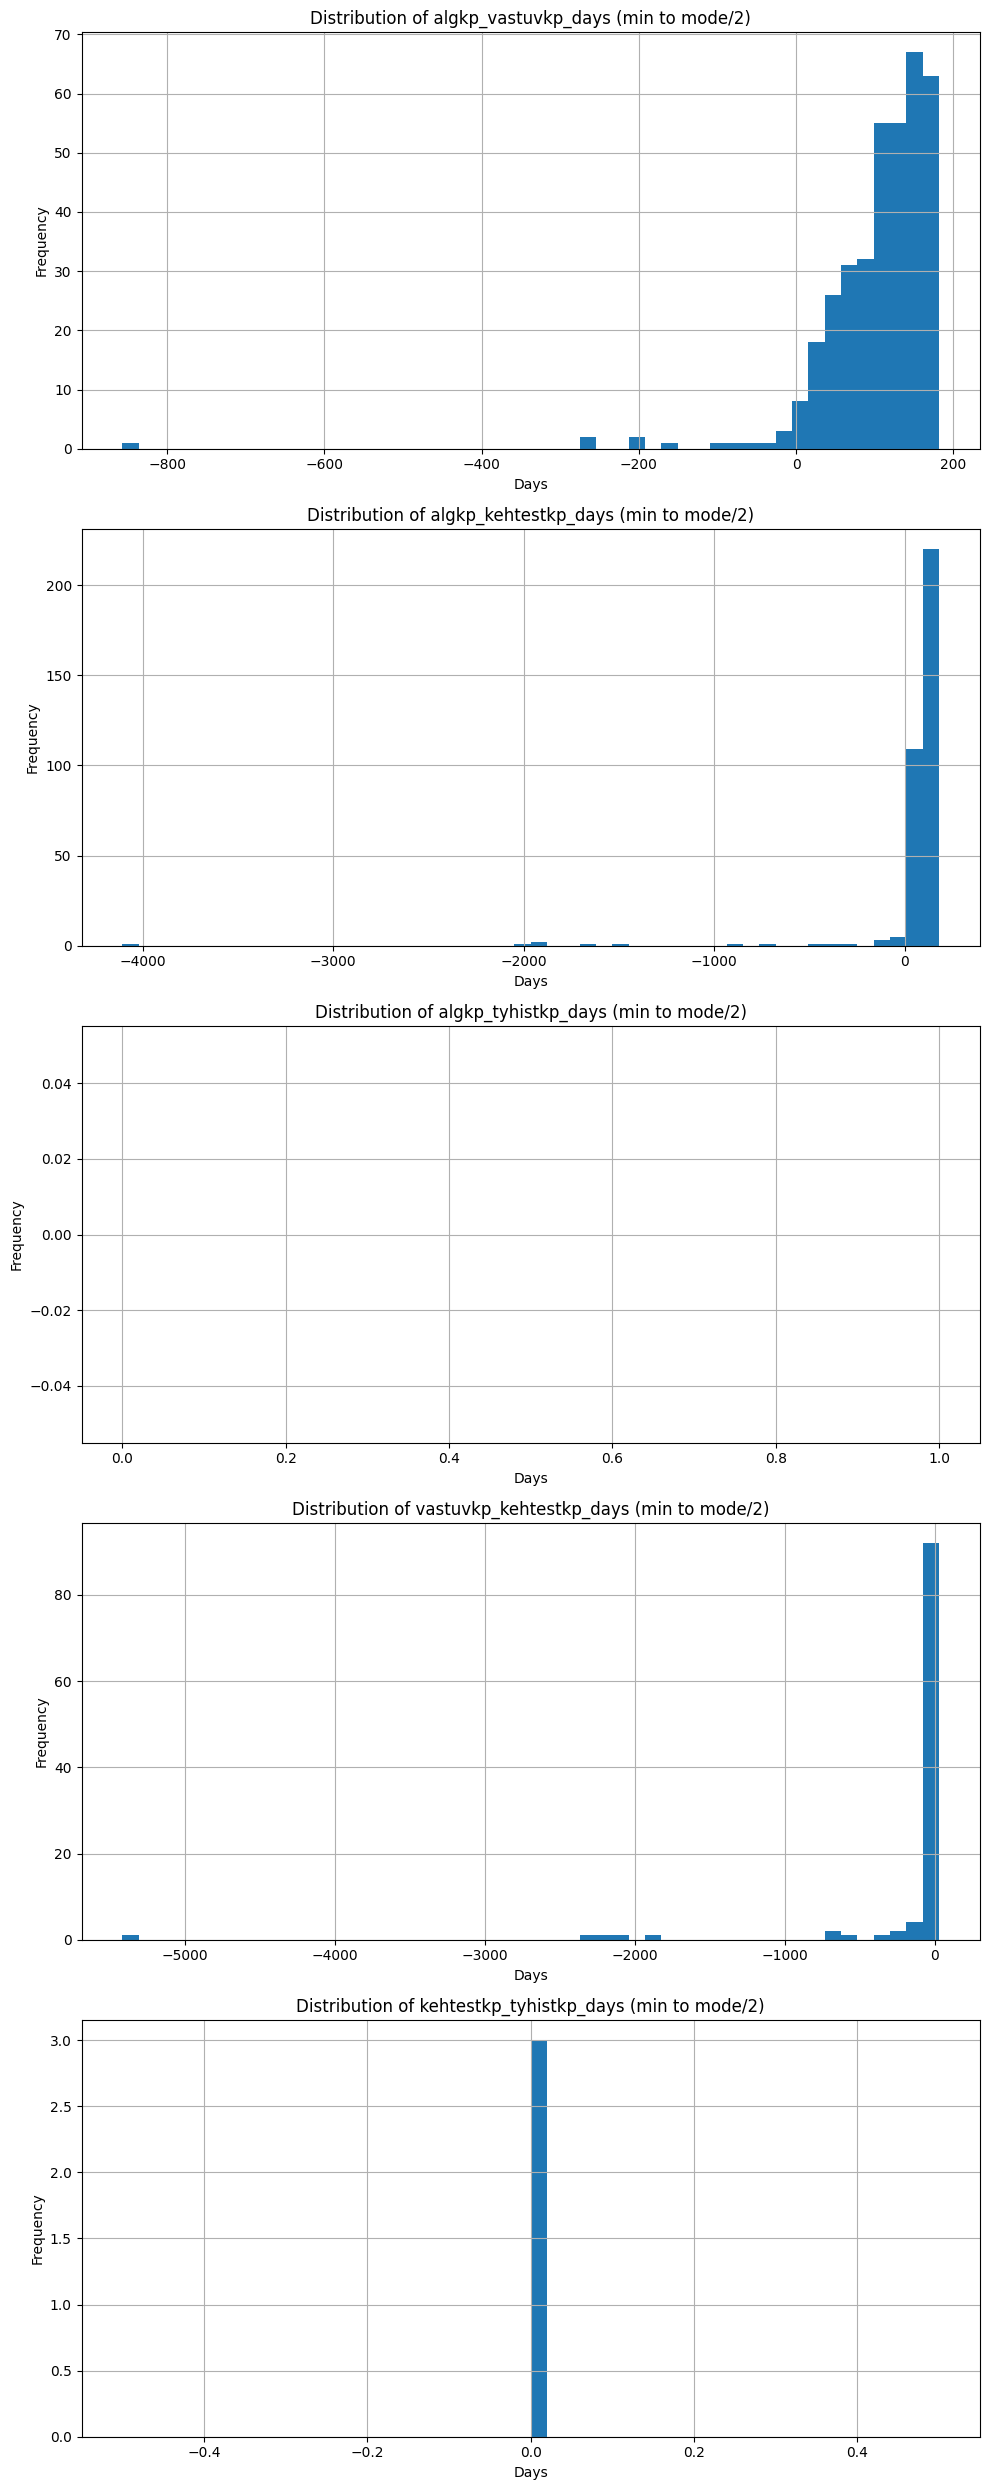

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Get a list of columns with calculated day differences
day_diff_cols = [col for col in gdfs['plank:detailplaneering'].columns if col.endswith('_days')]

# Create subplots for each day difference column
fig, axes = plt.subplots(len(day_diff_cols), 1, figsize=(10, 5 * len(day_diff_cols)), sharex=False)

# Plot the distribution for each column
for i, col in enumerate(day_diff_cols):
    ax = axes[i]
    data = gdfs['plank:detailplaneering'][col].dropna()  # Drop NaT values

    if len(data) > 0:  # Check if data is not empty
        # Calculate minimum and half the mode
        minimum = data.min()
        mode = data.mode()[0]  # Get the first mode (if multiple modes exist)
        half_mode = mode / 2

        # Filter data within the desired range
        filtered_data = data[(data >= minimum) & (data <= half_mode)]

        # Plot the histogram
        filtered_data.hist(ax=ax, bins=50)  # Adjust bins as needed
        ax.set_title(f'Distribution of {col} (min to mode/2)')
        ax.set_xlabel('Days')
        ax.set_ylabel('Frequency')
    else:
        ax.set_title(f'No data for {col}')

plt.tight_layout()
plt.show()

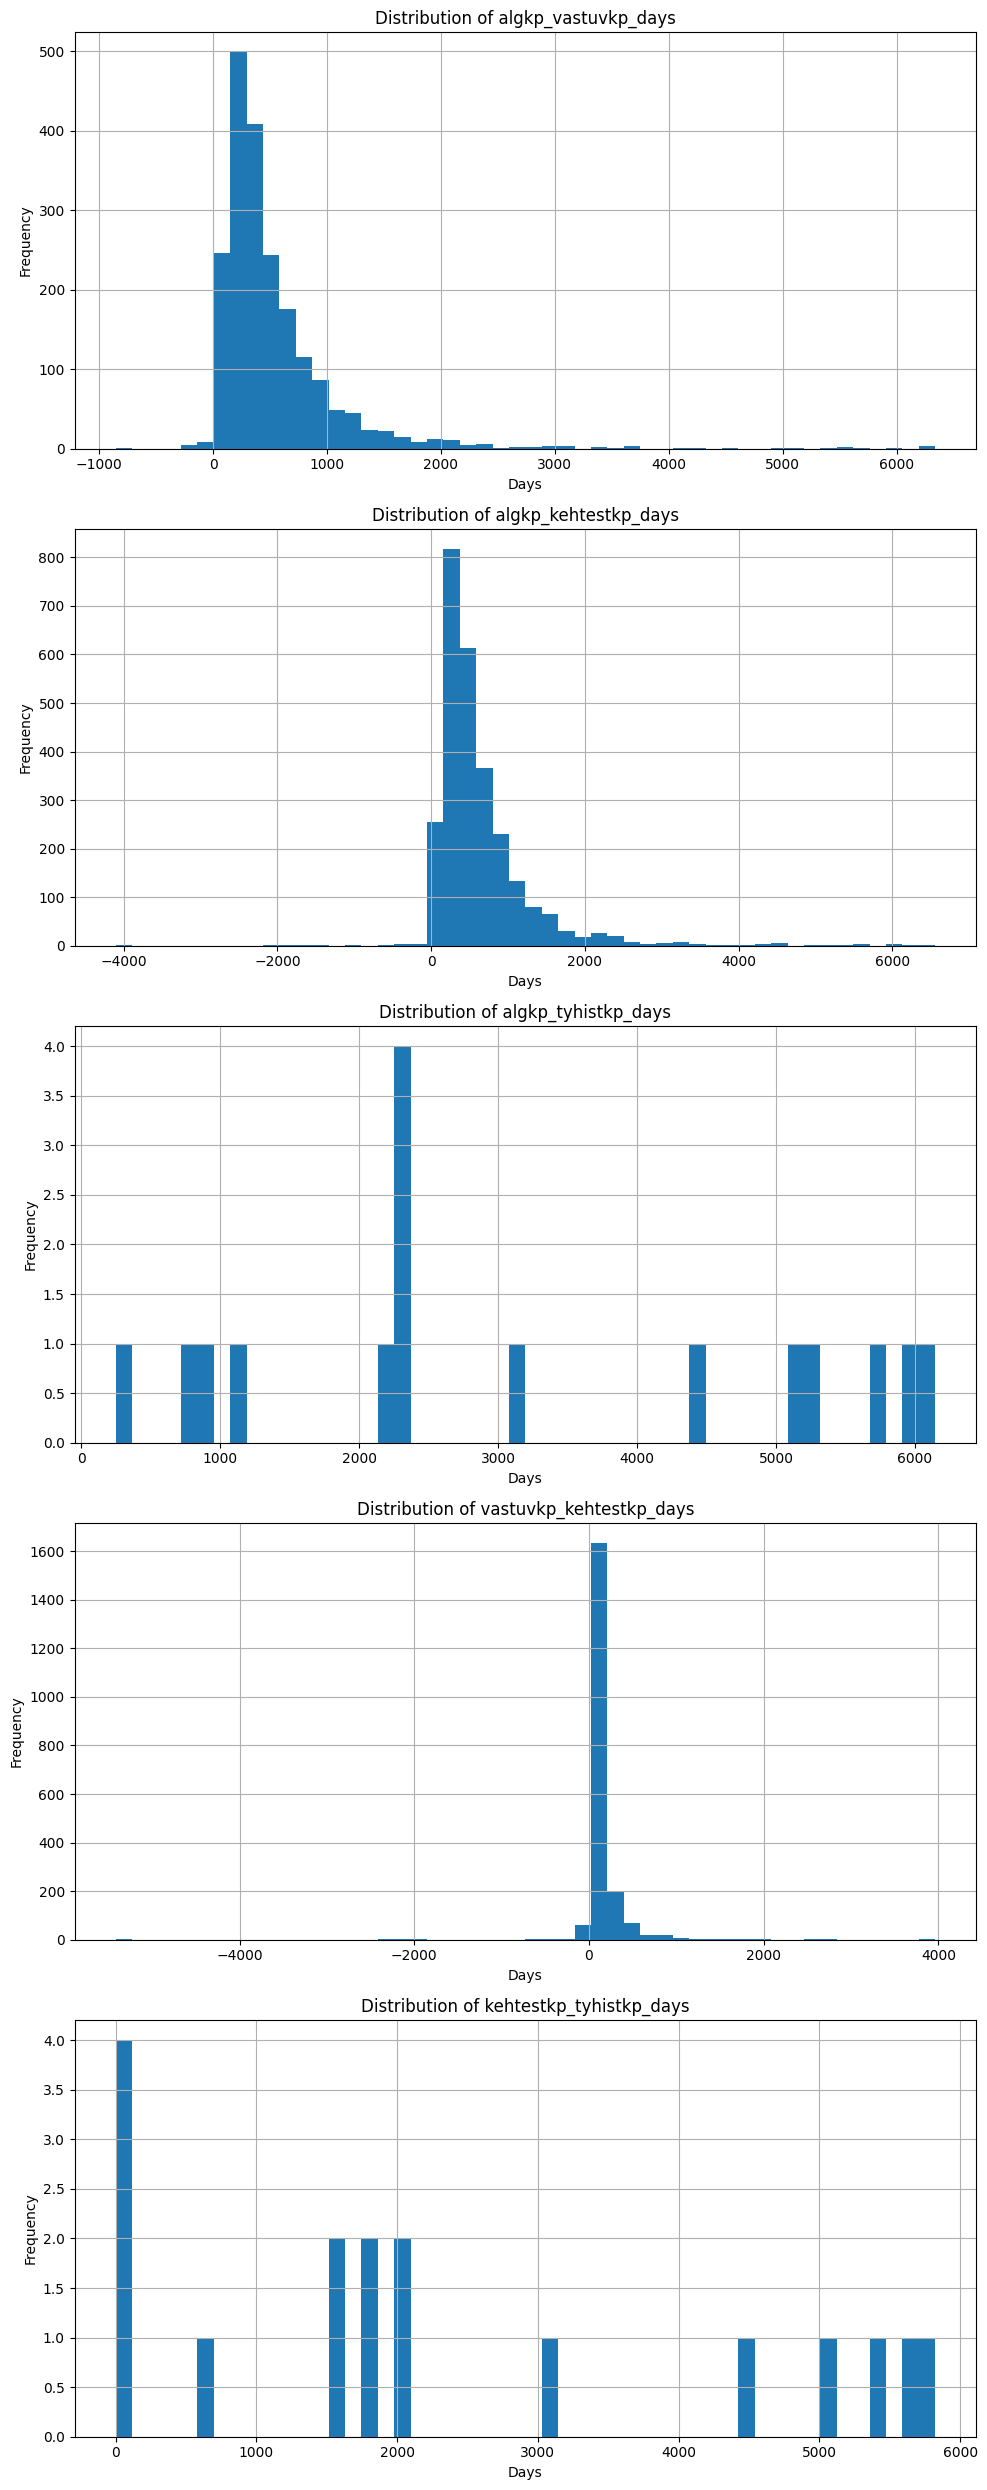

In [41]:
import matplotlib.pyplot as plt

# Get a list of columns with calculated day differences
day_diff_cols = [col for col in gdfs['plank:detailplaneering'].columns if col.endswith('_days')]

# Create subplots for each day difference column
fig, axes = plt.subplots(len(day_diff_cols), 1, figsize=(10, 5 * len(day_diff_cols)), sharex=False)  # Adjust figsize as needed

# Plot the distribution for each column
for i, col in enumerate(day_diff_cols):
    ax = axes[i]
    gdfs['plank:detailplaneering'][col].hist(ax=ax, bins=50)  # Adjust bins as needed
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

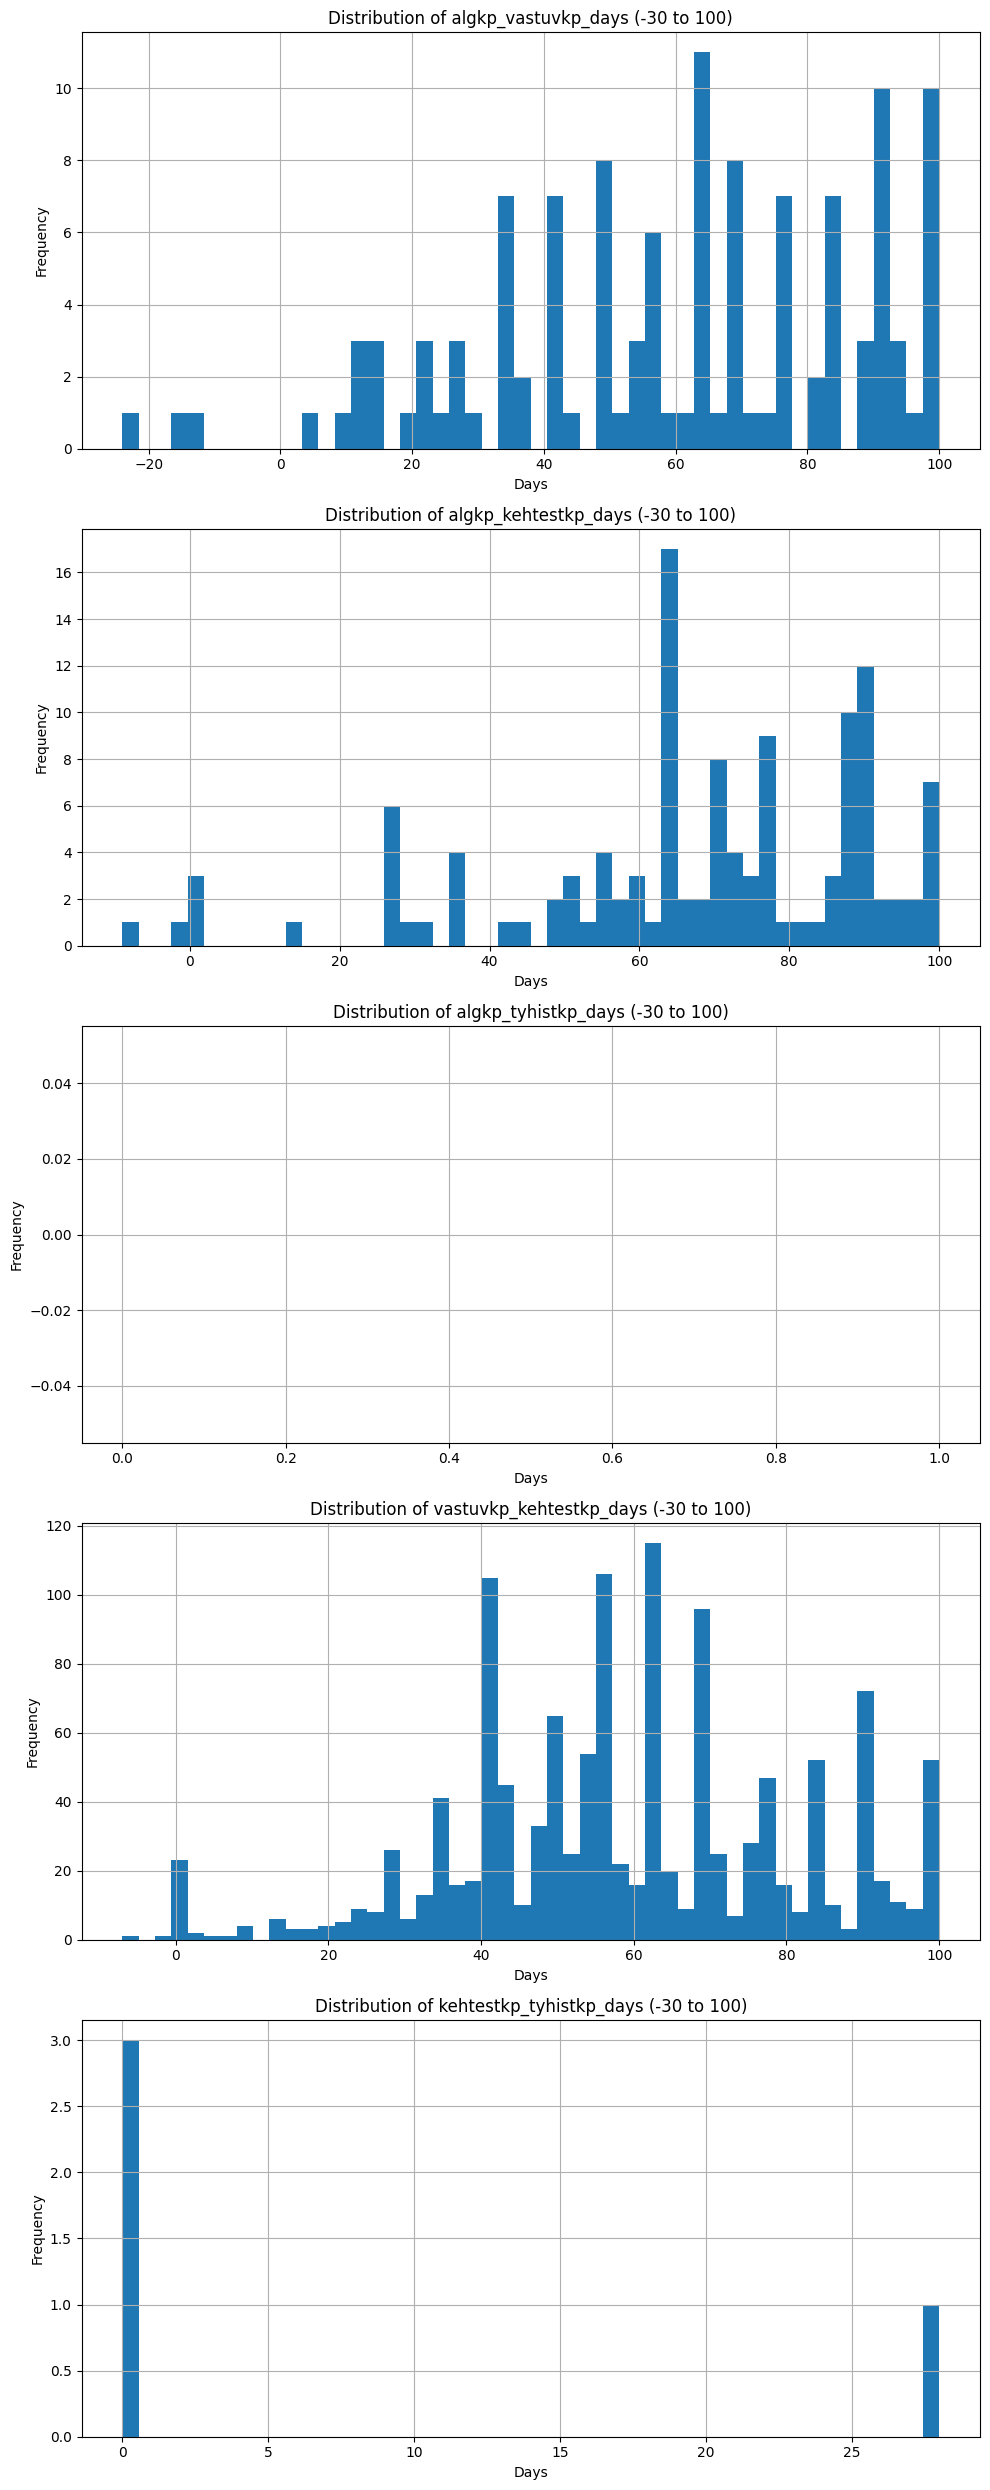

In [45]:
import matplotlib.pyplot as plt

# Get a list of columns with calculated day differences
day_diff_cols = [col for col in gdfs['plank:detailplaneering'].columns if col.endswith('_days')]

# Create subplots for each day difference column
fig, axes = plt.subplots(len(day_diff_cols), 1, figsize=(10, 5 * len(day_diff_cols)), sharex=False)

# Plot the distribution for each column
for i, col in enumerate(day_diff_cols):
    ax = axes[i]
    data = gdfs['plank:detailplaneering'][col].dropna()  # Drop NaT values

    # Filter data within the desired range
    filtered_data = data[(data >= -30) & (data <= 100)]

    # Plot the histogram
    filtered_data.hist(ax=ax, bins=50)  # Adjust bins as needed
    ax.set_title(f'Distribution of {col} (-30 to 100)')
    ax.set_xlabel('Days')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [43]:
# Get a list of columns with calculated day differences
day_diff_cols = [col for col in gdfs['plank:detailplaneering'].columns if col.endswith('_days')]

# Create a boolean mask to identify rows with values lower than 14
lower_than_14_mask = gdfs['plank:detailplaneering'][day_diff_cols].lt(14).any(axis=1)

# Filter the GeoDataFrame using the mask
lower_than_14_rows = gdfs['plank:detailplaneering'][lower_than_14_mask]

# Print the filtered rows
print(lower_than_14_rows)

                         gml_id                   lowerCorner  \
24    detailplaneering.30100225  6605697.910000 610400.230000   
60    detailplaneering.30100078  6543007.960000 420406.660000   
83    detailplaneering.30103362  6444867.199999 704553.880000   
106   detailplaneering.30100105  6592181.140000 580137.150000   
119   detailplaneering.30100234  6609013.130000 608246.030000   
...                         ...                           ...   
2556  detailplaneering.30102976  6474692.610000 674692.870000   
2703  detailplaneering.30103270  6592286.110000 579764.880000   
2711  detailplaneering.30101123  6604850.120000 592293.190000   
2769  detailplaneering.30103305  6583575.531900 666928.339500   
2795  detailplaneering.30101270  6488402.260000 585499.833669   

                       upperCorner     sysid      planid     kovid  \
24    6605756.940000 610478.380000  30100225         NaN   1910130   
60    6543300.540000 420753.500000  30100078         NaN      None   
83    644

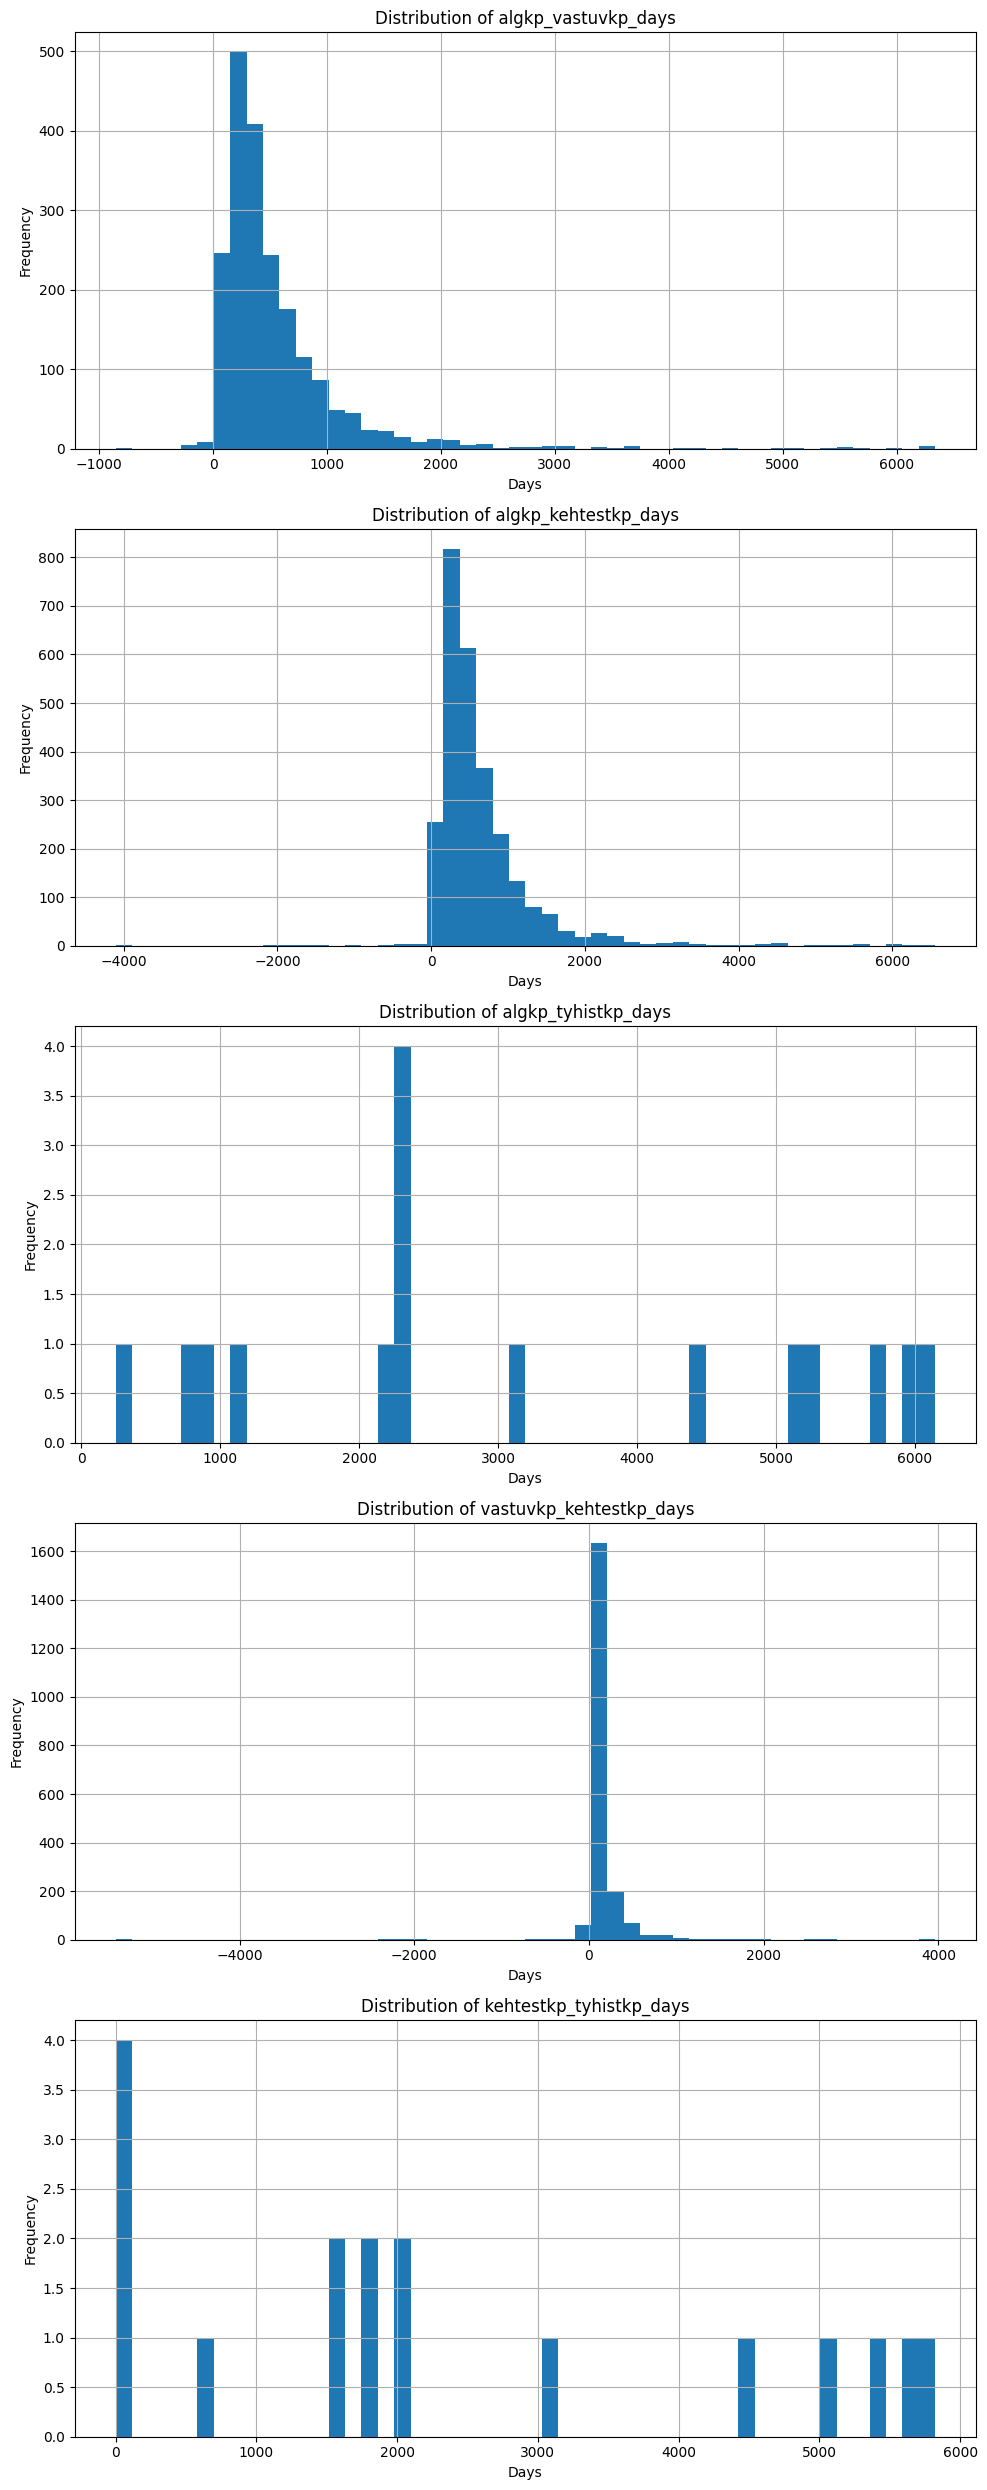

In [40]:
import matplotlib.pyplot as plt

# Get a list of columns with calculated day differences
day_diff_cols = [col for col in gdfs['plank:detailplaneering'].columns if col.endswith('_days')]

# Create subplots for each day difference column
fig, axes = plt.subplots(len(day_diff_cols), 1, figsize=(10, 5 * len(day_diff_cols)), sharex=False)  # Adjust figsize as needed

# Plot the distribution for each column
for i, col in enumerate(day_diff_cols):
    ax = axes[i]
    gdfs['plank:detailplaneering'][col].hist(ax=ax, bins=50)  # Adjust bins as needed
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Days')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()